# KC House Data
## 0.0 Business Case
The estate market is complex and highly competitive. There are a lot of buyers motivated by a wide range of reasons. As the demand is high, the tools/services available to assist people on the market are a plethora. Although there are a lot of eyes scrutinising the estate market, we feel there is still a lot of opportunities laying around.

We are a company working for property developers. We aim to maximise their return on investment on a short-term to medium-term basis. We have access to a county-wide database and, with the help of data science and market analysis techniques, we can highlight areas and properties with high potential. Our primary focus is on underpriced properties and regions with recent higher growth.
## 0.1 Importing Libraries and Global Settings

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

##############################
# notebook parameters

# import warnings
# warnings.filterwarnings('ignore')
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set(style='ticks', rc={'figure.figsize':(15,12)})

## 1. Exploratory Data Analysis

In [2]:
kc = pd.read_csv('./source/kc_house_data.csv', parse_dates=[1,14])

In [3]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955-01-01,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951-01-01,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933-01-01,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965-01-01,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987-01-01,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
kc.describe(include='all', datetime_is_numeric=True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,...,21597.000000,21597.000000,21597,21597,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.580474e+09,2014-10-29 04:20:38.171968512,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,...,7.657915,1788.596842,NaN,1971-01-01 00:15:16.127239876,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
min,1.000102e+06,2014-05-02 00:00:00,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,...,3.000000,370.000000,NaN,1900-01-01 00:00:00,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,NaN,1951-01-01 00:00:00,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,NaN,1975-01-01 00:00:00,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,NaN,1997-01-01 00:00:00,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,NaN,2015-01-01 00:00:00,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
kc[kc['yr_renovated']==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955-01-01,0.0,98178,47.5112,-122.257,1340,5650
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965-01-01,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987-01-01,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001-01-01,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995-01-01,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009-01-01,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014-01-01,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009-01-01,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004-01-01,0.0,98027,47.5345,-122.069,1410,1287


Some properties have gone through a renovation process. It is interesting to see that, out of the 21597 properties available in the dataset, 17011 of those were not renovated. 78% is a surprisingly high ratio, and it probably reflects an imperfect collection of data or only the renovations requiring a permit were recorded (substantial/structural home improvement).

It is worth examining this parameter as a considerate home improvement can drastically improve the value of a property in a short amount of time.

## 1.1 Missing Values

In [6]:
kc[kc['sqft_basement']=='?']

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995-01-01,0.0,98003,47.3097,-122.327,2238,6819
18,16000397,2014-12-05,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,...,7,1200,?,1921-01-01,0.0,98002,47.3089,-122.210,1060,5095
42,7203220400,2014-07-07,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,...,9,3595,?,2014-01-01,0.0,98053,47.6848,-122.016,3625,5639
79,1531000030,2015-03-23,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,...,10,3450,?,2002-01-01,0.0,98010,47.3420,-122.025,3350,39750
112,2525310310,2014-09-16,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,...,7,1160,?,1980-01-01,0.0,98038,47.3624,-122.031,1540,11656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,3226049565,2014-07-11,504600.0,5,3.00,2360,5000,1.0,0.0,0.0,...,7,1390,?,2008-01-01,0.0,98103,47.6931,-122.330,2180,5009
21447,1760650900,2014-07-21,337500.0,4,2.50,2330,4907,2.0,0.0,0.0,...,7,2330,?,2013-01-01,NaN,98042,47.3590,-122.081,2300,3836
21473,6021503707,2015-01-20,352500.0,2,2.50,980,1010,3.0,NaN,0.0,...,8,980,?,2008-01-01,0.0,98117,47.6844,-122.387,980,1023
21519,2909310100,2014-10-15,332000.0,4,2.50,2380,5737,2.0,0.0,0.0,...,7,2380,?,2010-01-01,0.0,98023,47.2815,-122.356,2380,5396


In [7]:
kc.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

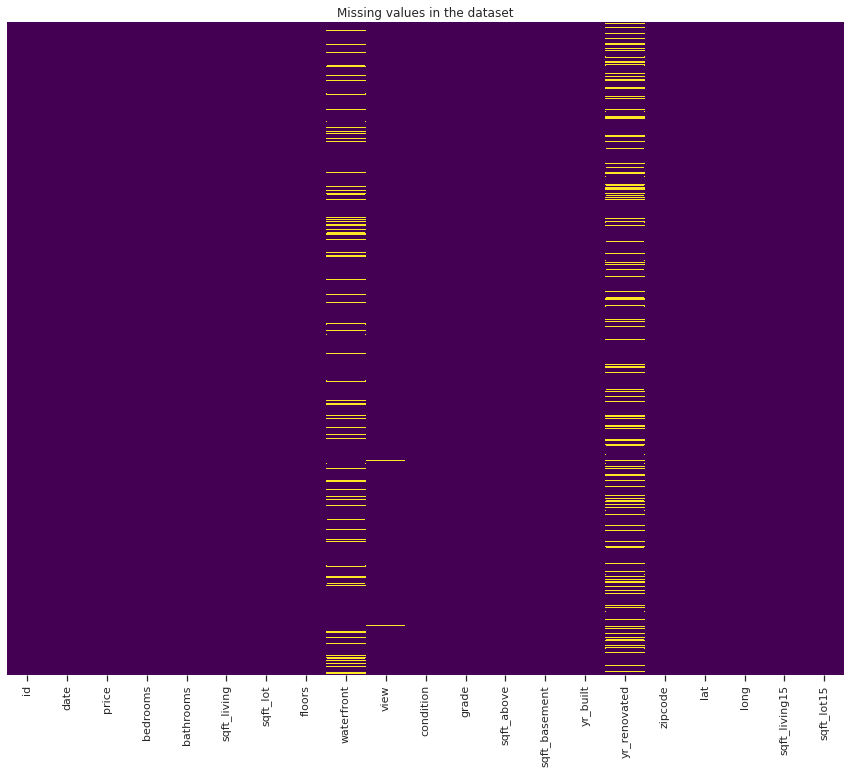

In [8]:
sns.heatmap(kc.isnull(), yticklabels=False, cbar=False, cmap='viridis');
plt.title('Missing values in the dataset');

As the preliminary analysis suggests, there are a few data issues that need addressing:

* `waterfront`, although has 2376 NA values, is too complex to be filled in (and won't be used during the rest of the analysis). We will leave the field as is.
* `views` has 63 NA that we are going to replace with 0.
* `yr_renovated` has 17011 zero-values, it will be changed to NaN
* a property has 33 bedrooms, we think 3 is more likely
* `sqft_basement` had 454 '?' values, they will be changed to 0.
* In case we need to track something down, we are also going to generate a dictionary of the properties we have modified during this analysis: `properties_data_altered` {key = 'property ID', value = 'altered field'}

In [9]:
# sqft_basement
properties_data_altered = {}
for i in range(0,len(kc['id'])-1):
        if kc['sqft_basement'][i] == '?':
            kc['sqft_basement'][i] = 0
        properties_data_altered[kc['id'][i]] = 'sqft_basement'

# 33 bedrooms house
properties_data_altered[kc[kc['bedrooms']==33].iloc[0]['id']] = '33_bedrooms'
kc['bedrooms'] = kc['bedrooms'].replace(33,3)

# view
for i in kc[kc['view'].isnull()]['id']:
    properties_data_altered[i] = 'views'
kc['view'] = kc['view'].fillna(0)

# yr_renovated
for i in kc[kc['yr_renovated']=='0.0']['id']:
    properties_data_altered[i] = 'yr_renovated'
kc['yr_renovated'] = kc['yr_renovated'].replace('0.0', np.nan)

<ipython-input-9-46342bf02129>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc['sqft_basement'][i] = 0


Some fields have the wrong data type, let's fix this:
(note that fields such as bathrooms/bedrooms shouldn't be continuous but we are keeping them as such to allow for linear regression)

In [10]:
# lines are commented to allow us to work on non categorised data
kc['id'] = kc['id'].astype(str)
# kc['bathrooms'] = kc['bathrooms'].astype(str)
# kc['bedrooms'] = kc['bedrooms'].astype(str)
# kc['condition'] = kc['condition'].astype(str)
# kc['floors'] = kc['floors'].astype(str)
# kc['grade'] = kc['grade'].astype(str)
kc['sqft_basement'] = kc['sqft_basement'].astype(float)
# kc['view'] = kc['view'].astype(str)
kc['waterfront'] = kc['waterfront'].astype(str)
kc['yr_renovated'] = pd.to_datetime(kc['yr_renovated'])
kc['zipcode'] = kc['zipcode'].astype(str)

### 1.1 Generating the Subdatasets

In [11]:
duplicate_properties = kc[kc.duplicated(['id'], keep=False)].reset_index(drop=True)
kc = kc.sort_values('date').drop_duplicates('id', keep='last')

In [12]:
# A house has been sold 3 times during the time interval.
duplicate_properties.drop(duplicate_properties.index[317], inplace=True)

In [13]:
# Calculating base values for our analysis
duplicate_properties['time_diff'] = duplicate_properties['date'].diff().dt.days
duplicate_properties['price_diff'] = duplicate_properties['price'].diff()
duplicate_properties['rate_of_price_increase'] = duplicate_properties['price_diff'] / pd.to_numeric(duplicate_properties['time_diff'])

In [14]:
duplicate_properties.drop_duplicates('id', keep='last', inplace=True)

### 1.2 Depreciating Properties
6 properties have lost value over time. We want to make sure there is no environmental reasons we should be aware of before recommending a property. At first sight, there does not seem to be any geographical reason for this depreciation. But let's put them on a map to confirm this assumption.

In [15]:
duplicate_properties[duplicate_properties['price_diff'] < 0]['zipcode']

15     98053
85     98125
119    98006
183    98107
237    98010
275    98033
Name: zipcode, dtype: object

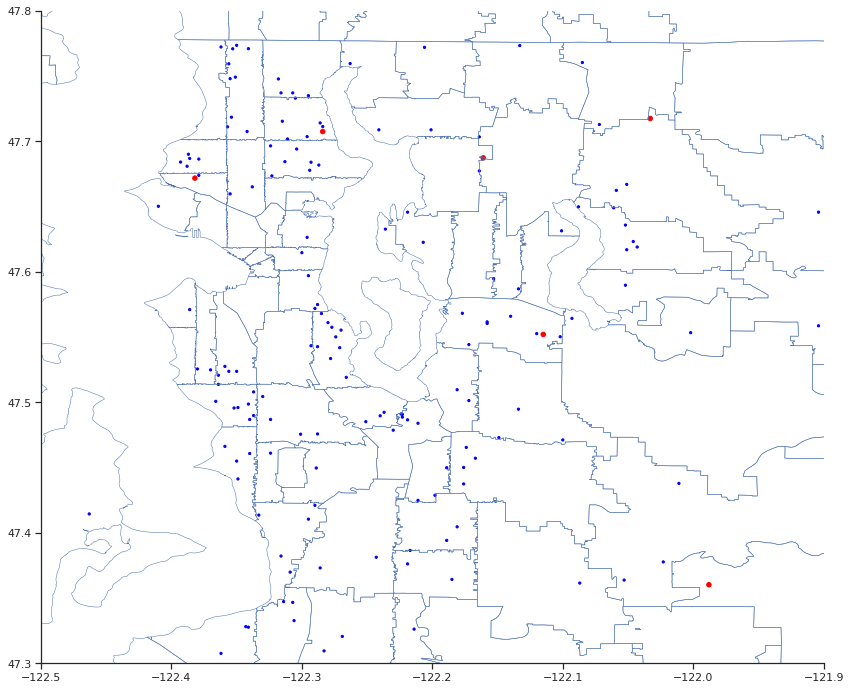

In [16]:
counties = gpd.read_file('./source/Zip_Codes/Zip_Codes.shp')
geodf = gpd.GeoDataFrame(duplicate_properties, 
                         geometry=gpd.points_from_xy(duplicate_properties['long'], 
                                                     duplicate_properties['lat'])
                        )

geodf['color'] = geodf['price_diff'].apply(lambda x: 'red' if x < 0 else 'blue')
geodf['markersize'] = geodf['price_diff'].apply(lambda x: 20 if x < 0 else 5)

ax = counties.boundary.plot(linewidth=.5)
ax.set_ylim([47.3, 47.8])
ax.set_xlim([-122.5, -121.9])
geodf.plot(ax=ax, color=geodf['color'], markersize=geodf['markersize']);
sns.despine()

The properties that have lost money over time seem to be randomly spread across the counties. The factors contributing to that depreciation appear do not appear to be environmental.

## 2. Analysing the Market Growth Based on Properties with Mutliple Sales Over the Observed Period

In [17]:
hotZC = duplicate_properties.groupby(['zipcode'])['rate_of_price_increase'].mean().sort_values(ascending=False)

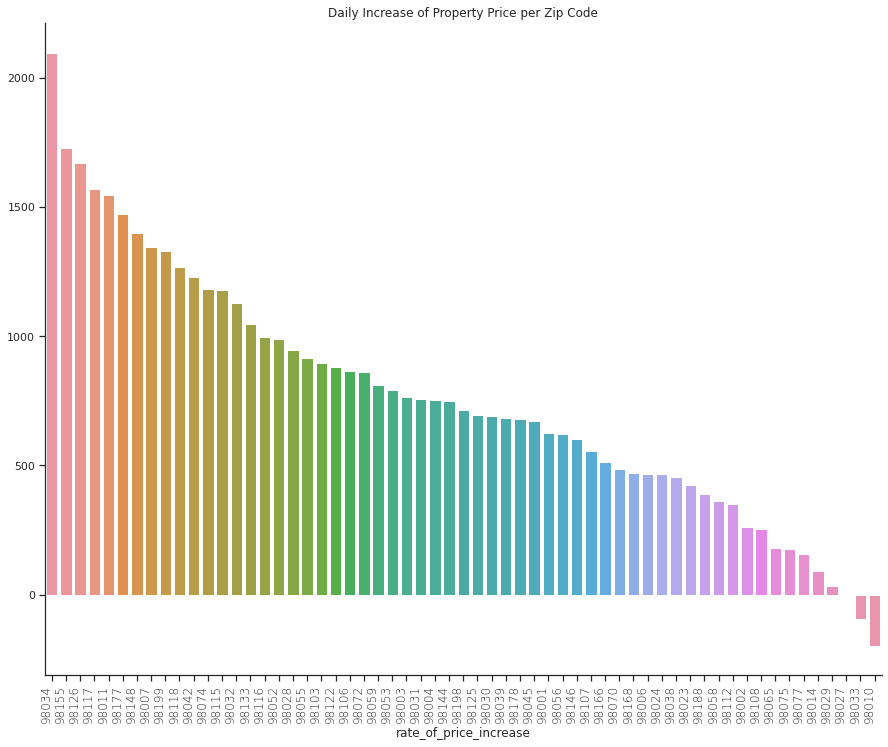

In [18]:
graph = sns.barplot(x=hotZC.index,
                    y=hotZC[::-1].values,
                    data=hotZC,
                    orient='vertical'
                    )
graph.set_xticklabels(hotZC.index,
                      horizontalalignment='right',
                      rotation=90,
                      fontweight='light',
                      fontsize='medium');
plt.title('Daily Increase of Property Price per Zip Code');
sns.despine()

### 2.1 Mapping of Price Variations per Zip Codes

In [19]:
mapkc = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')
mapkc.rename(columns={'ZIPCODE':'zipcode'}, inplace=True)

In [20]:
mapkc = mapkc.merge(hotZC, how='left', on='zipcode')

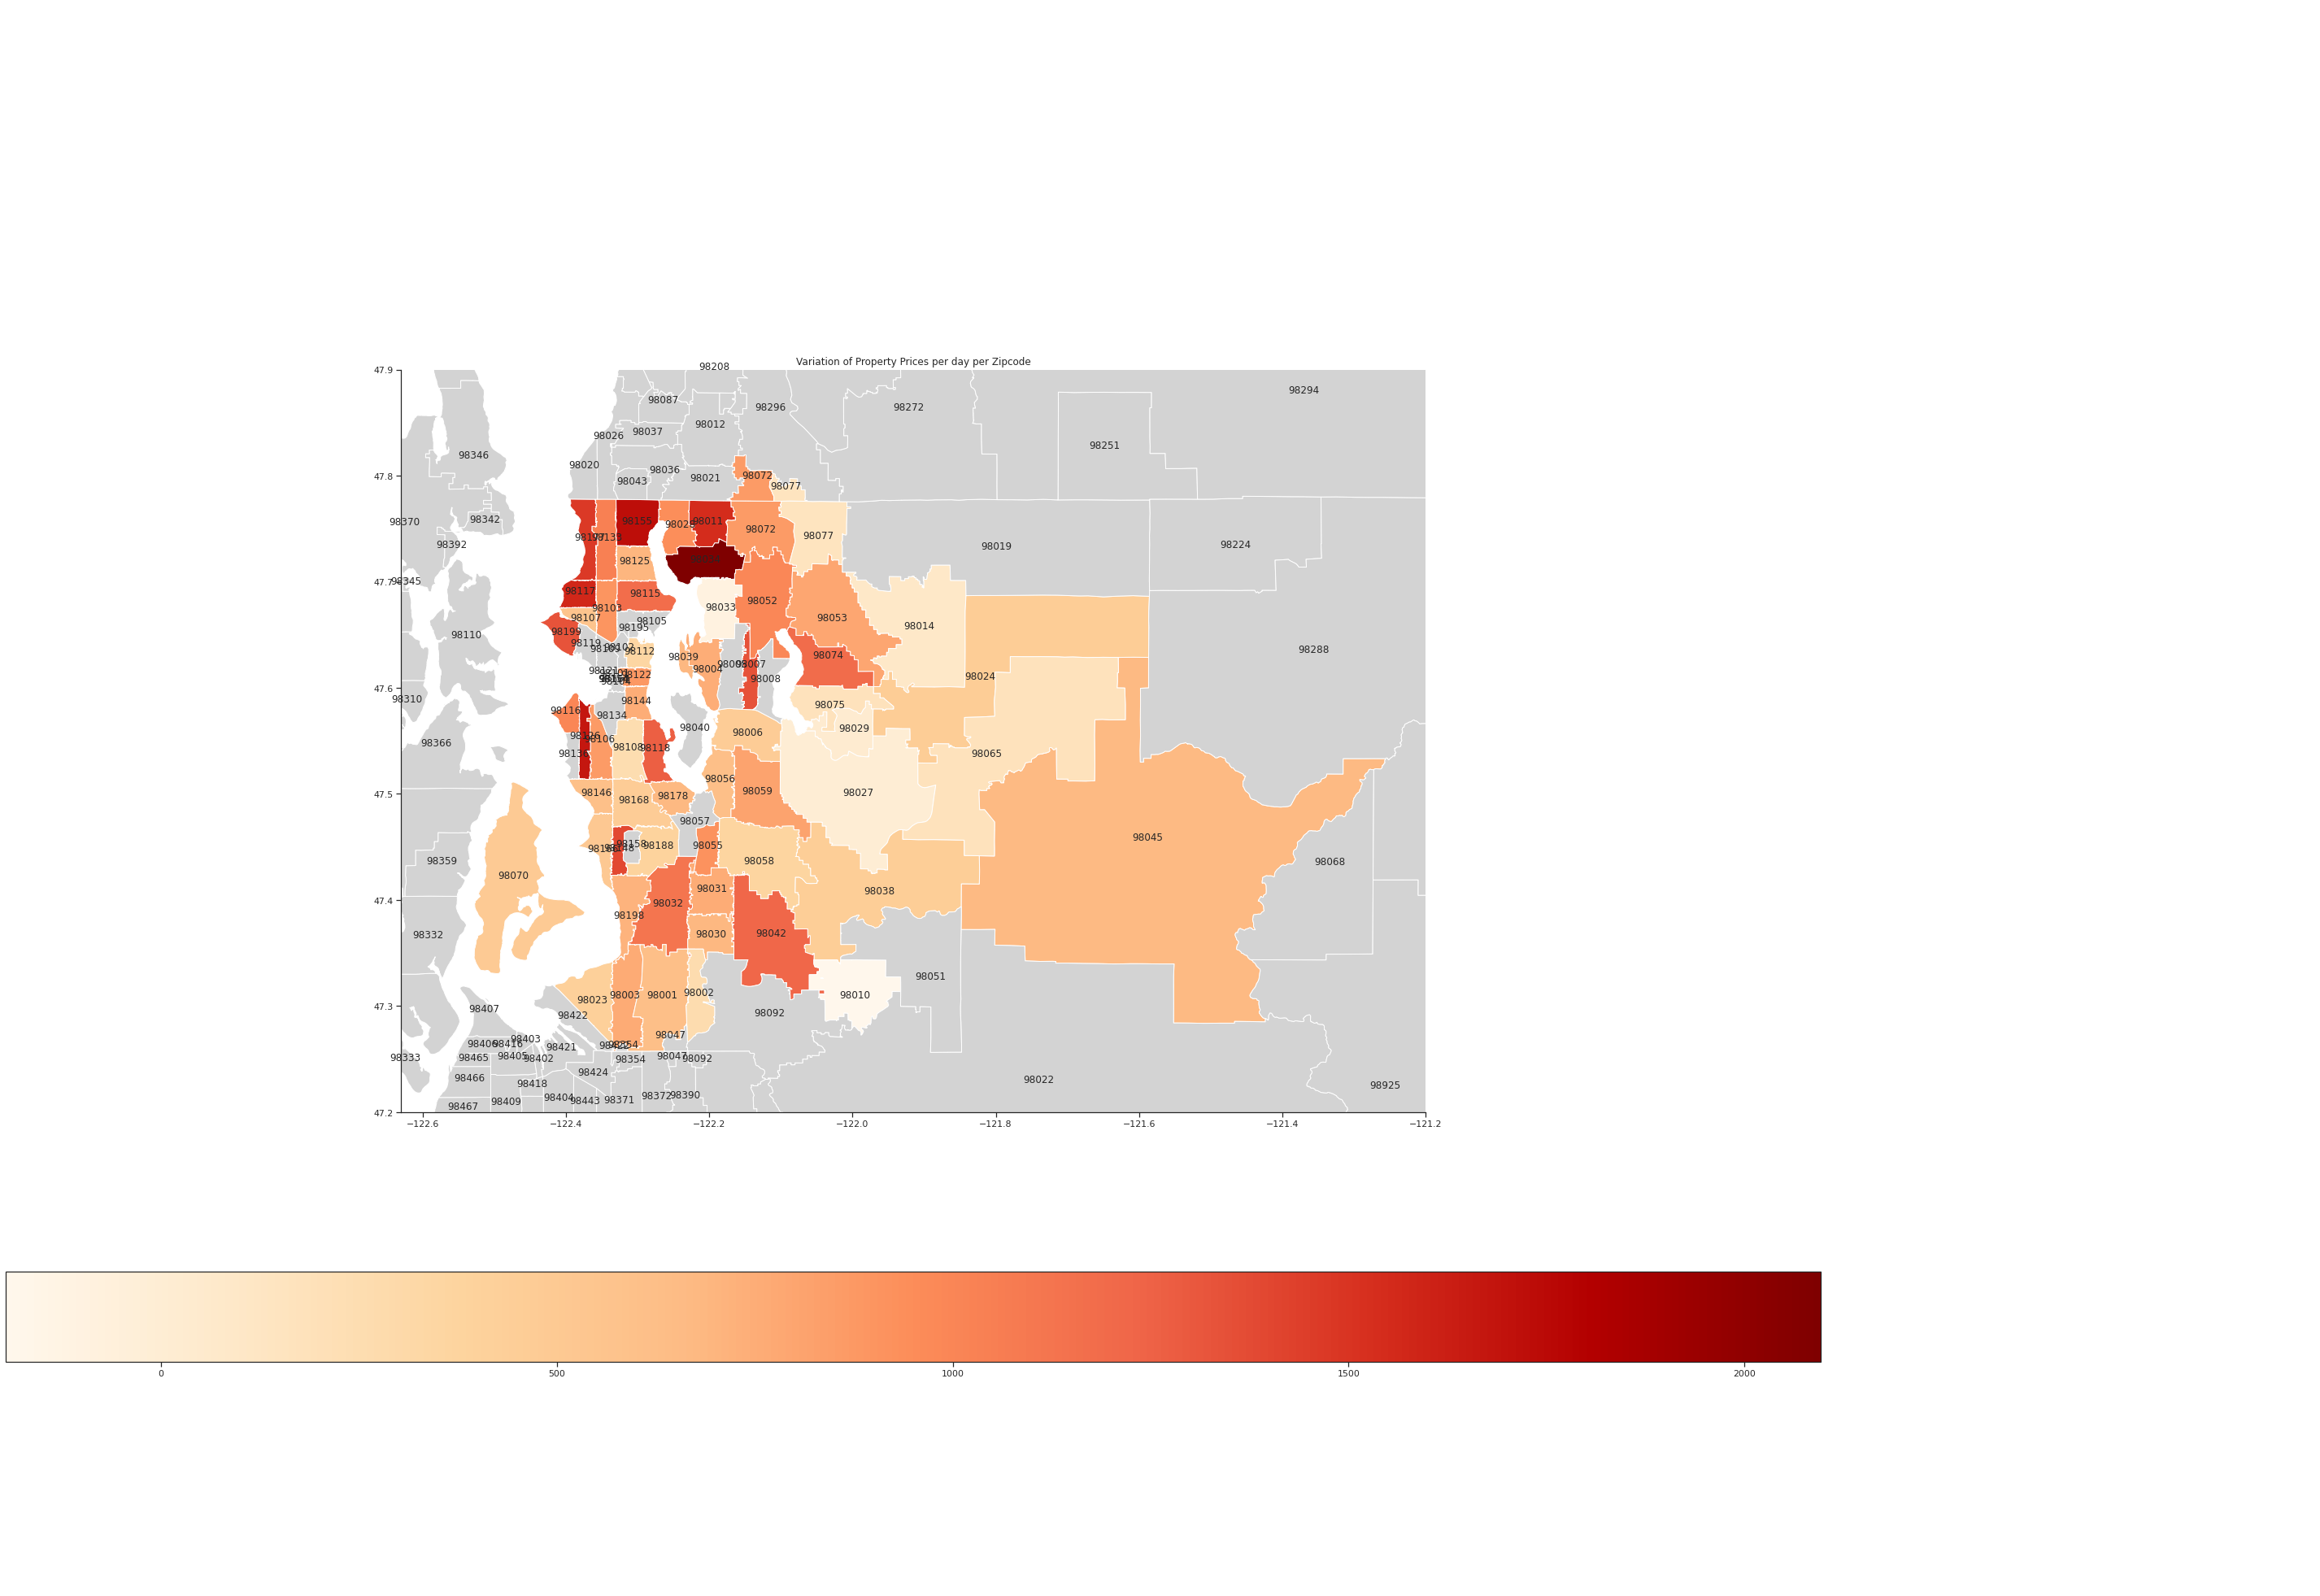

In [21]:
gdf = gpd.GeoDataFrame(mapkc, geometry='geometry')


gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]


gdf.plot(column='rate_of_price_increase', 
         legend=True,
         cmap='OrRd',
         legend_kwds={'orientation': "horizontal"},
         missing_kwds={'color': 'lightgrey'},
         figsize=(40,24)
        );

plt.ylim([47.2, 47.9]);
plt.xlim([-122.63, -121.2]);
plt.title('Variation of Property Prices per day per Zipcode');

for i, row in gdf.iterrows():
    plt.annotate(s=row['zipcode'], xy=row['coords'],
                 horizontalalignment='center')

sns.despine()

It is interesting to note that properties sold more than once in the observed period are all located in the bay area. This area seems to have a more active real estate market than the rest of the county.

It might be interesting to gather more data for other counties so we could compare long term price variations, but for now, we can define our area of interest to the northern bay area. More specifically, the following zip codes:
* 98034
* 98011
* 98028
* 98155
* 98133
* 98177
* 98125
* 98115
* 98103
* 98117
* 98107
* 98199

We chose these zip codes because they show the most significant increase in property price over the observed year, but also because of their geographical proximity to one another.

## 3. Seasonality

In [22]:
# our area of focus, based on the price evolution analysed in kc_duplicated and their geographical location
focus_zipcodes = ['98034',
                  '98011',
                  '98028',
                  '98155',
                  '98133',
                  '98177',
                  '98125',
                  '98115',
                  '98103',
                  '98117',
                  '98107',
                  '98199'
                 ]

# our main dataset
kayCee = kc[kc['zipcode'].isin(focus_zipcodes)] # 4905 houses

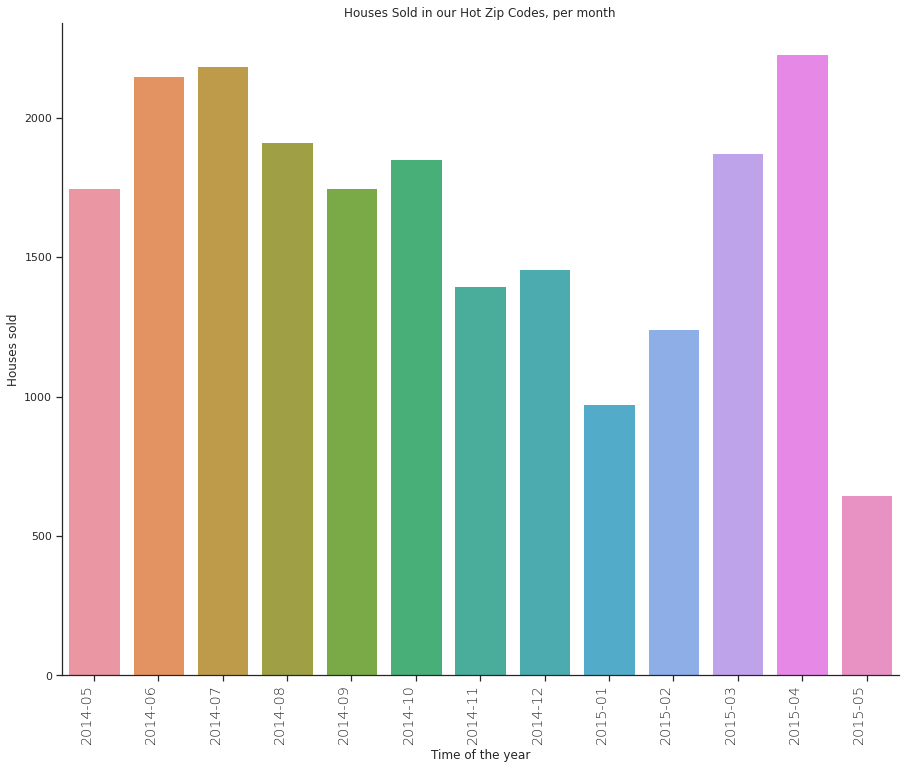

In [23]:
##############################
# generate a dataset to analyse the seasonality of data

seasonality_df = kc.copy() #copy main data
seasonality_df.insert(3,"month",0) #add a column for time month
seasonality_df.insert(4,"year",0) #add a column for time year
seasonality_df["date"] = pd.to_datetime(seasonality_df['date']) #convert date column to datetime objects from object
seasonality_df["month"] = seasonality_df["date"].dt.month #extract month
seasonality_df["year"] = seasonality_df["date"].dt.year #extract year
per_month = seasonality_df.set_index('date').groupby(pd.Grouper(freq='M'))['id'].count() #create a Pandas series with the values we need

##############################
# generate the seasonality graph

chart = sns.barplot(x=per_month.index, 
                    y=per_month.values
                   )
xlabels = ['2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05']
chart.set_xlabel('Time of the year')
chart.set_ylabel('Houses sold');

chart.set_xticklabels(xlabels,
                      rotation=90, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');
plt.title('Houses Sold in our Hot Zip Codes, per month');
sns.despine()

## 4. Renovations
### 4.1 Non-Renovated Developments Within the Hot Zip Codes
Non renovated properties are generally cheaper than renovated ones.

The properties showing the highest potential return are the ones in poor conditions (1 and 2). If brought to condition 3 would on average sell for 542,000 (condition 1 to 3, 3 bedrooms).

In [24]:
no_renovation = kayCee[kayCee.yr_renovated=='1970-01-01 00:00:00.000000000']

for i in [1, 2, 3, 4, 5]:
    print(
        f'Condition {i}',\
        'Amount of houses:', no_renovation[no_renovation.condition==i]['price'].count(),\
        'Minimum price:', no_renovation[no_renovation.condition==i]['price'].min(),\
        'Median price:', no_renovation[no_renovation.condition==i]['price'].median(),\
        'Maximum price:', no_renovation[no_renovation.condition==i]['price'].max(),\
        '*'*20,\
        sep='\n'
        )

Condition 1
Amount of houses:
4
Minimum price:
125000.0
Median price:
233000.0
Maximum price:
352950.0
********************
Condition 2
Amount of houses:
19
Minimum price:
237000.0
Median price:
420550.0
Maximum price:
975000.0
********************
Condition 3
Amount of houses:
2384
Minimum price:
130000.0
Median price:
465000.0
Maximum price:
4500000.0
********************
Condition 4
Amount of houses:
969
Minimum price:
195000.0
Median price:
476000.0
Maximum price:
3070000.0
********************
Condition 5
Amount of houses:
410
Minimum price:
238000.0
Median price:
570000.0
Maximum price:
3000000.0
********************


### 4.2 Renovated Development Within the Hot Zip Codes
For properties already renovated, the price tag is slightly higher but some properties still have a high profit potential; the renovated_1 property could yield 33% - minus renovation costs - if brought to a condition 3 (compared to the average price of 2 bedrooms house)

In [25]:
renovated = kayCee[kayCee.yr_renovated!='1970-01-01 00:00:00.000000000']

for i in [1, 2, 3, 4, 5]:
    print(
        f'Condition {i}',\
        'Amount of houses:', renovated[renovated.condition==i]['price'].count(),\
        'Minimum price:', renovated[renovated.condition==i]['price'].min(),\
        'Median price:', renovated[renovated.condition==i]['price'].median(),\
        'Maximum price:', renovated[renovated.condition==i]['price'].max(),\
        '*'*20,
        sep='\n'
        )

Condition 1
Amount of houses:
1
Minimum price:
305000.0
Median price:
305000.0
Maximum price:
305000.0
********************
Condition 2
Amount of houses:
2
Minimum price:
400000.0
Median price:
524975.0
Maximum price:
649950.0
********************
Condition 3
Amount of houses:
744
Minimum price:
90000.0
Median price:
499000.0
Maximum price:
3200000.0
********************
Condition 4
Amount of houses:
273
Minimum price:
230000.0
Median price:
483000.0
Maximum price:
2230000.0
********************
Condition 5
Amount of houses:
99
Minimum price:
291500.0
Median price:
625000.0
Maximum price:
1580000.0
********************


/usr/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


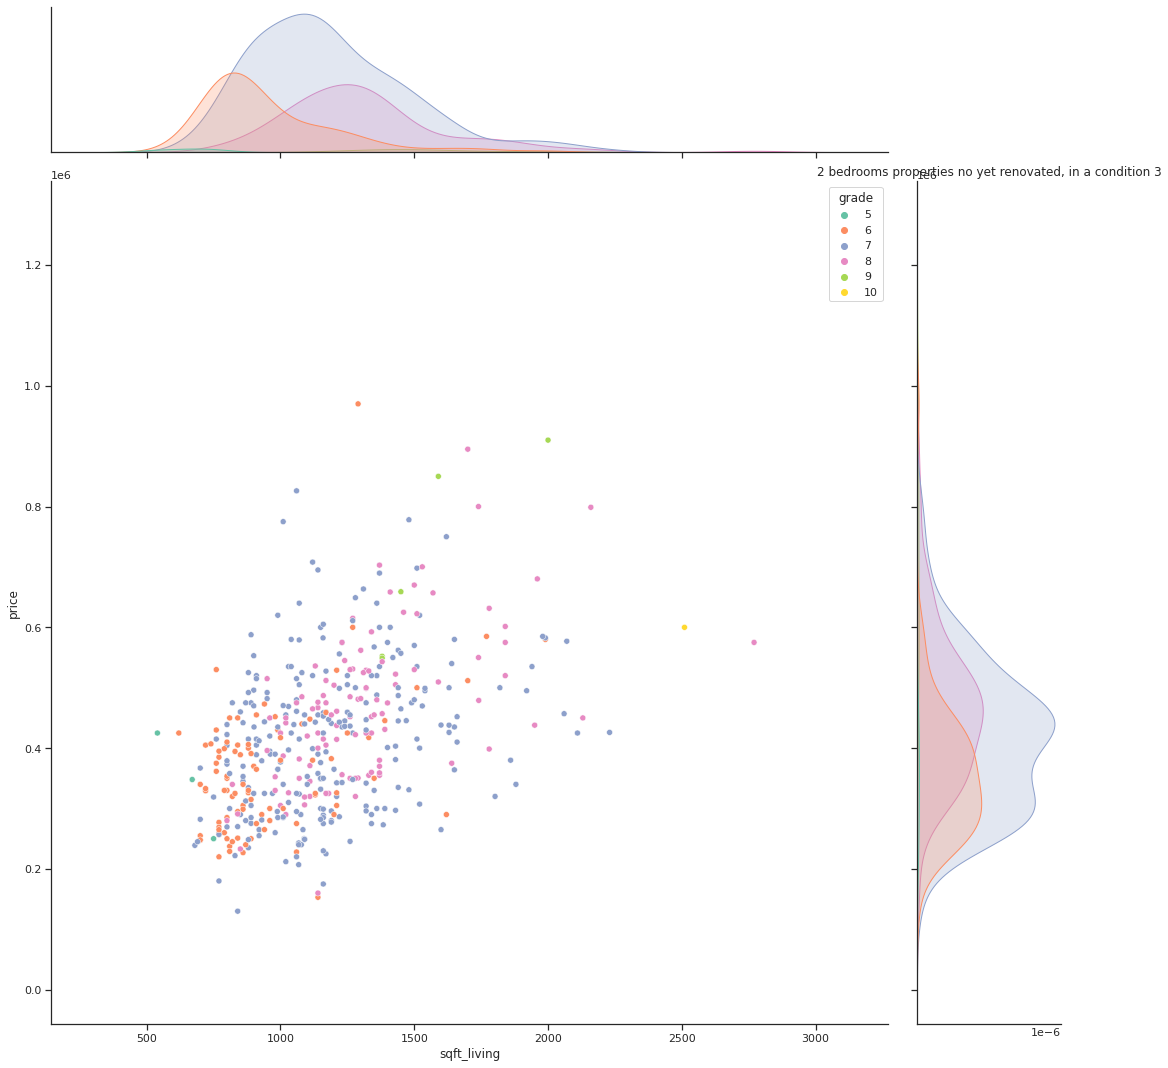

In [26]:
data = no_renovation[(no_renovation['condition']==3) & (no_renovation['bedrooms']==2)]

sns.jointplot(x='sqft_living',
              y='price',
              data=data,
              height=15,
              hue='grade',
              palette='Set2'
             )

plt.title('2 bedrooms properties no yet renovated, in a condition 3');
sns.despine()

## 5. Statistical Models

In [27]:
##############################
# generate dataframes
kc_hot_zipcodes = kc[kc.zipcode.isin(focus_zipcodes)]
kc_not_hot_zipcodes = kc[~kc.zipcode.isin(focus_zipcodes)]

### 5.1 Model for the Hot Zip Codes

/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


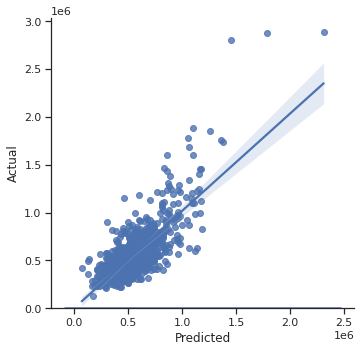

In [28]:
##############################
# scale the variables

scaler = StandardScaler()
X = kc_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y = kc_hot_zipcodes['price']
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

##############################
# Split generating population/testing population

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

model_kc = LinearRegression()
model_kc.fit(X_train, y_train) #training the algorithms
y_pred = model_kc.predict(X_test)

##############################
# generate graph

model_kc_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# sns.set_style('dark')
g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_results)

sns.distplot(y_pred);

In [29]:
##############################
# model parameters

coeff_kc = pd.DataFrame(model_kc.coef_, scaled_X.columns, columns=['Scaled Coefficients (Hot Zip Codes)'])
model_kc.fit(X,y)

# Evaluating performance
r2 = model_kc.score(X,y)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc.intercept_
est_B = model_kc.coef_
print('constant: {}'.format(round(est_a,4)))
print('coefficients:  {} estimated'.format(est_B.round(4)))
coeff_kc

R2 = 0.56
constant: -614392.8295
coefficients:  [-4.06928709e+04 -2.00931062e+04  2.03097200e+02 -6.42400000e-01
 -6.48299220e+03  4.93123139e+04  1.07605211e+05] estimated


,Scaled Coefficients (Hot Zip Codes)
bedrooms,-38025.352120
bathrooms,-13495.044722
sqft_living,153841.296208
sqft_lot,-4020.420791
floors,-4749.848706
condition,33520.115670
grade,97985.885740


### 5.2 Model for the Non-Hot Zip Codes

/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


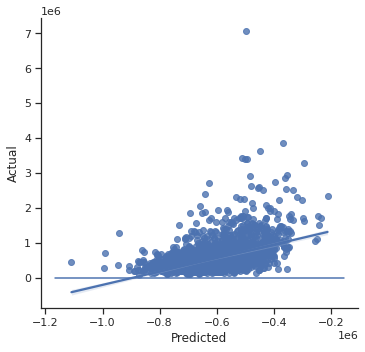

In [30]:
##############################
# scale the variables

X_not_hot_zipcodes = kc_not_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                                          'floors', 'condition', 'grade']]
y_not_hot_zipcodes = kc_not_hot_zipcodes['price']
scaled_X_not_hot_zipcodes = pd.DataFrame(scaler.fit_transform(X_not_hot_zipcodes), 
                                         columns=X_not_hot_zipcodes.columns)

##############################
# Split generating population/testing population

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scaled_X_not_hot_zipcodes, y_not_hot_zipcodes,
                                                            test_size=0.2, random_state=0)
model_kc_not_hot_zipcodes = LinearRegression()  
model_kc_not_hot_zipcodes.fit(X_train_2, y_train_2) #training the algorithms
y_pred_not_hot_zipcodes = model_kc.predict(X_test_2)

##############################
# generate graph

model_kc_not_hot_zipcdoes_results = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_not_hot_zipcodes})
g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_not_hot_zipcdoes_results)
sns.distplot(y_pred_not_hot_zipcodes);

In [31]:
##############################
# model parameters

coeff_kc_not_hot_zipcodes = pd.DataFrame(model_kc_not_hot_zipcodes.coef_, scaled_X_not_hot_zipcodes.columns,
                                         columns=['Scaled Coefficients (Other Zip Codes)'])  
model_kc.fit(X_not_hot_zipcodes,y_not_hot_zipcodes)

# evaluating performance
r2 = model_kc.score(X_not_hot_zipcodes,y_not_hot_zipcodes)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# understanding the LEARNED model
est_a = model_kc_not_hot_zipcodes.intercept_
est_B = model_kc_not_hot_zipcodes.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc_not_hot_zipcodes

R2 = 0.57
constant: 540998.6305
coeficients:  [-45304.4908   -381.7549 222231.5454 -14669.792  -20942.0074  41289.0984
 129663.9776] estimated


,Scaled Coefficients (Other Zip Codes)
bedrooms,-45304.490784
bathrooms,-381.754937
sqft_living,222231.545372
sqft_lot,-14669.792032
floors,-20942.007403
condition,41289.098449
grade,129663.977637


### 5.3 Comparing Prices Between Hot Zip Codes and Non-Hot Zip Codes

/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


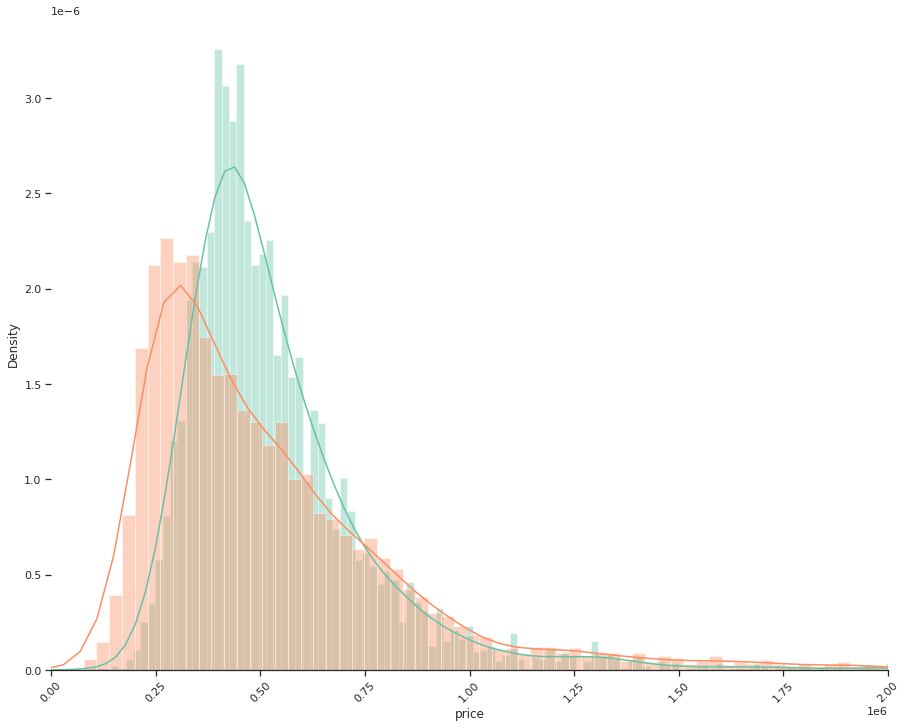

In [32]:
colors = sns.color_palette('Set2',2)

# sns.set_style('dark')

sns.distplot(kc_hot_zipcodes['price'], bins=250,  color = colors[0])
sns.despine(left=True)
sns.distplot(kc_not_hot_zipcodes['price'], bins=250,  color = colors[1])
sns.despine(left=True)
plt.xticks(rotation=45)
plt.xlim(0, 2000000)

plt.show()

### 5.4 Comparing Grades Between Hot Zip Codes and Non-Hot Zip Codes

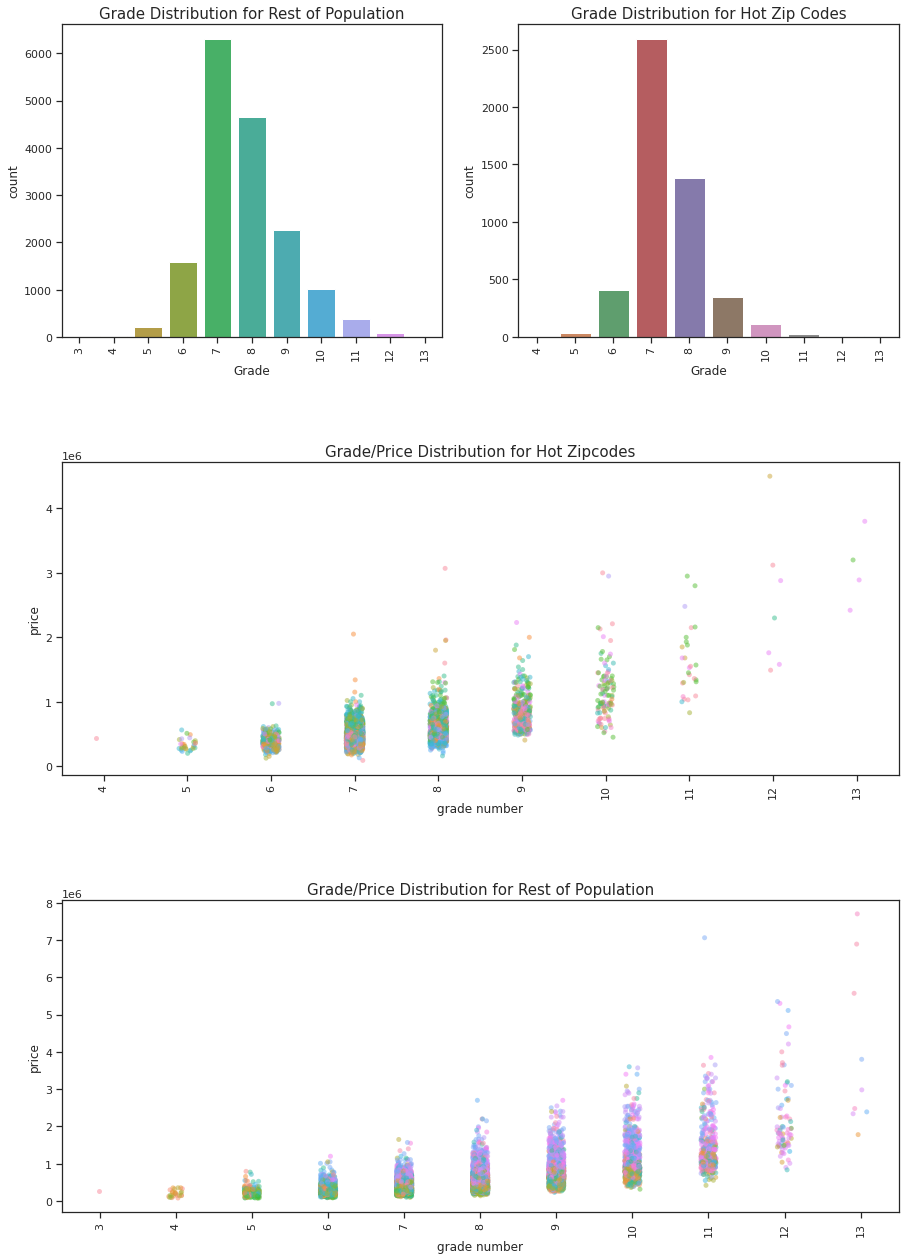

In [33]:
kc_grade = kc_hot_zipcodes.sort_values(by=['grade'])
kc_grade_full = kc_not_hot_zipcodes.sort_values(by =['grade'])

plt.subplots_adjust(hspace = 0.4, top = 1.5)

ax1 = plt.subplot(321)
ax1 = sns.countplot(x="grade", data=kc_grade_full,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Grade Distribution for Rest of Population", fontsize=15)
ax1.set_xlabel("Grade")

ax2 = plt.subplot(322)
ax2 = sns.countplot(x="grade", data=kc_grade,
                    ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Grade Distribution for Hot Zip Codes", fontsize=15)
ax2.set_xlabel("Grade")

ax3 = plt.subplot(312)
ax3 = sns.stripplot(x="grade", y="price",
                    data=kc_grade, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax3.set_title("Grade/Price Distribution for Hot Zipcodes", fontsize=15)
ax3.set_xlabel("grade number")
ax3.set_ylabel("price")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.legend().remove()

ax4 = plt.subplot(313)
ax4 = sns.stripplot(x="grade", y="price",
                    data=kc_grade_full, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax4.set_title("Grade/Price Distribution for Rest of Population", fontsize=15)
ax4.set_xlabel("grade number")
ax4.set_ylabel("price")
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

plt.legend().remove()
plt.show()